In [66]:
include("Optimization/FairClassification.jl")
include("Optimization/FairRegression.jl")
include("Metrics/ClassificationMetrics.jl")
include("Metrics/RegressionMetrics.jl")
include("Utils/DataGeneration.jl");

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [12]:
using PyPlot

In [67]:
# Generate classification data
n = 100
d = 2
p = 2
X, y, group_assignments = generate_random_classification_data(n, d, p, σ=2);

In [74]:
w, b = svm_classifier(X, y)
w_fair_convex, b_fair_convex = fair_convex_svm_classifier(X, y, group_assignments)
w_fair, b_fair = fair_svm_classifier(X, y, group_assignments, use_warm_start=true);

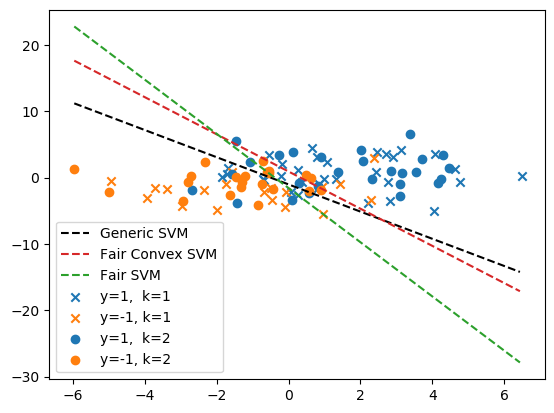

In [75]:
markers = ["x", "o"]
colors = ["tab:blue", "tab:orange"]
for k=1:p
    mask_positive = (y .== 1) .& (group_assignments .== k)
    mask_negative = (y .== -1) .& (group_assignments .== k)
    plt.scatter(X[mask_positive, 1], X[mask_positive, 2], 
        label=string("y=1,  ", "k=", k), marker=markers[k], color=colors[1])
    plt.scatter(X[mask_negative, 1], X[mask_negative, 2], 
        label=string("y=-1, ", "k=", k), marker=markers[k], color=colors[2])
end

X1_grid = minimum(X[:,1]):0.1:maximum(X[:,1])
X2_grid = minimum(X[:,2]):0.1:maximum(X[:,2])
plt.plot(X1_grid, (b .- w[1].*X1_grid)/w[2], 
    color="k", linestyle="--", label="Generic SVM")
plt.plot(X1_grid, (b_fair_convex .- w_fair_convex[1].*X1_grid)/w_fair_convex[2], 
    color="tab:red", linestyle="--", label="Fair Convex SVM")
plt.plot(X1_grid, (b_fair .- w_fair[1].*X1_grid)/w_fair[2], 
    color="tab:green", linestyle="--", label="Fair SVM")
plt.legend();

In [76]:
svm_fairness_summary(X, y, group_assignments, w, b)

False positive rate discrepency: 0.153
False negative rate discrepency: 0.034
False discovery rate discrepency: 0.129
False omission rate discrepency: 0.055
Positive rate discrepency: 0.044


In [77]:
svm_fairness_summary(X, y, group_assignments, w_fair_convex, b_fair_convex)

False positive rate discrepency: 0.12
False negative rate discrepency: 0.053
False discovery rate discrepency: 0.063
False omission rate discrepency: 0.141
Positive rate discrepency: 0.061


In [78]:
svm_fairness_summary(X, y, group_assignments, w_fair, b_fair)

False positive rate discrepency: 0.01
False negative rate discrepency: 0.002
False discovery rate discrepency: 0.053
False omission rate discrepency: 0.062
Positive rate discrepency: 0.036


# Regression Example

In [16]:
# Generate regression data
n = 100
d = 1
p = 2
X, y, group_assignments = generate_random_regression_data(100, 1, 2)

In [25]:
# Fit models
β = lasso_regressor(X, y)
β_fair = fair_lasso_regressor(X, y, group_assignments);

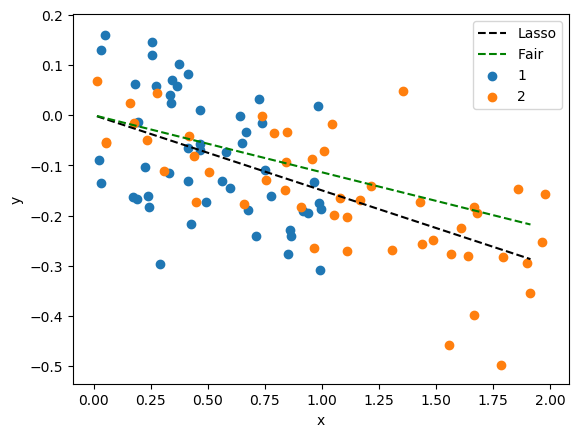

In [26]:
# Visualize models
for k=1:p
    plt.scatter(X[group_assignments .== k], y[group_assignments .== k], label=k)
end
X_grid = minimum(X):0.1:maximum(X)
plt.plot(X_grid, β.*X_grid, color="k", linestyle="--", label="Lasso")
plt.plot(X_grid, β_fair.*X_grid, color="g", linestyle="--", label="Fair")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [27]:
regressor_fairness_summary(X, y, group_assignments, β)

Mean undershoot discrepency: 0.012
Mean overshoot discrepency: 0.015
Mean value discrepency: 0.083


In [28]:
regressor_fairness_summary(X, y, group_assignments, β_fair)

Mean undershoot discrepency: 0.019
Mean overshoot discrepency: 0.003
Mean value discrepency: 0.063
